In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from importlib import reload
from time import time
import matplotlib

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
ptm_idr_df = pd.read_csv('ptm_idr.csv')
ptm_idr_df

,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,...,nAA_20_180_pae,nAA_24_180_nopae,nAA_24_180_pae,nAA_28_180_nopae,nAA_28_180_pae,protein_number,nAA_24_180_pae_smooth10,disordered,ordered,pred_disordered
0,O00151,K,22,1,0,0,0,0,0,0,...,37,81,48,110,64,20,65.904762,0.0,1.0,0
1,O00151,K,71,0,0,0,0,0,0,0,...,52,80,74,87,80,20,68.523810,0.0,1.0,0
2,O00151,K,87,0,0,0,0,0,1,0,...,8,98,12,139,19,20,34.238095,0.0,1.0,1
3,O00151,T,34,0,0,0,0,0,0,0,...,41,94,63,113,82,20,65.380952,0.0,1.0,0
4,O00168,S,82,0,0,0,0,0,0,0,...,14,45,16,56,19,21,13.761905,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10808,Q9Y6W3,S,697,0,0,0,0,0,0,0,...,53,82,70,109,84,3046,81.285714,0.0,1.0,0
10809,Q9Y6W3,S,700,0,0,0,0,0,0,0,...,57,91,78,112,92,3046,78.333333,0.0,1.0,0
10810,Q9Y6W6,K,380,0,0,0,0,0,0,0,...,35,112,55,185,79,3047,101.571429,0.0,1.0,0
10811,Q9Y6Y9,Y,131,0,0,0,0,0,0,0,...,63,103,85,120,107,3048,68.238095,0.0,1.0,0


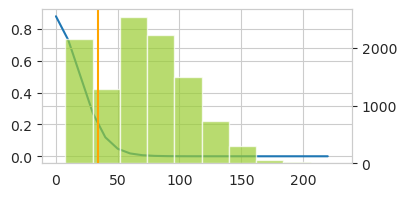

In [135]:
scale = -10
shift = 20
def logistic(x, scale, shift):
    return 1 / (1 + np.exp(-(x - shift) / scale))
xs = np.arange(0, np.max(ptm_idr_df['nAA_24_180_pae_smooth10']), 10)
ys = logistic(xs, scale, shift)
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.plot(xs, ys);
ax = axs.twinx()
ax.hist(ptm_idr_df['nAA_24_180_pae_smooth10'], color='yellowgreen', alpha=0.7)
plt.axvline(thresh, c='orange');
# plt.xlim([0, 100]);

In [133]:
scales = np.arange(-50, 0, 10)
shifts = np.arange(0, 100, 10)
print(np.var(ptm_idr_df['disordered']))
for scale in scales:
    for shift in shifts:
        pred = logistic(ptm_idr_df['nAA_24_180_pae_smooth10'], scale, shift)
        var_yf = np.var(pred - ptm_idr_df['disordered'])
        print(scale, shift, var_yf)

0.1457963626695672
-50 0 0.09651679573267503
-50 10 0.09447626509251923
-50 20 0.09319699997071877
-50 30 0.09271418546931526
-50 40 0.09300568358005493
-50 50 0.09399831514609368
-50 60 0.09558151591674229
-50 70 0.0976251374641708
-50 80 0.09999754177076559
-50 90 0.10258054184997578
-40 0 0.0916053969173806
-40 10 0.08838257013436511
-40 20 0.08647358615653217
-40 30 0.08598457499935999
-40 40 0.08686949597102445
-40 50 0.08894585753460908
-40 60 0.09193632246577513
-40 70 0.0955234323462027
-40 80 0.09940358338967026
-40 90 0.10332895632568671
-30 0 0.08675419985324923
-30 10 0.08101509816069322
-30 20 0.0777353708903581
-30 30 0.07729288261450264
-30 40 0.07960207735332718
-30 50 0.08417157732722867
-30 60 0.09025207948970235
-30 70 0.09701117773041533
-30 80 0.10369509968916184
-30 90 0.10975261105726163
-20 0 0.08490804679732801
-20 10 0.07311388126826625
-20 20 0.0663523823287156
-20 30 0.06606436069333427
-20 40 0.07191799886911683
-20 50 0.08241506623644447
-20 60 0.095527812

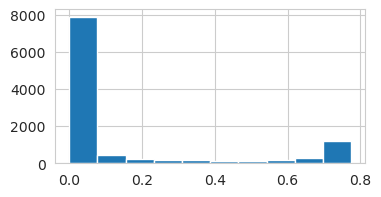

In [136]:
scale = -10
shift = 20
ptm_idr_df['pred_disordered'] = logistic(ptm_idr_df['nAA_24_180_pae_smooth10'], scale, shift)
plt.figure(figsize=(4, 2))
plt.hist(ptm_idr_df['pred_disordered']);

In [143]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(100), np.log10(N - 1000), num=5, base=10).astype(int)
n_trial = 200
ptm_names = ['p', 'ub']
alpha = 0.1
grid_spacing = 1e-3
parallelize = False
print_every = 100
save = False
save_fname = 'sampling-sites-wor-cis-logistic-110822.npz'

mu1maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
omaici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
oclaci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
ocov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            lab_idx = np.random.choice(len(ptm_idr_df), n, replace=False)
            result = utils.get_odds_ratio_betting_ci(
                ptm_idr_df, ptm_name, lab_idx, alpha, grid_spacing=grid_spacing,
                parallelize=parallelize, verbose=False, n_cores=n_cores
            )
            o, o_mai_ci, o_cla_ci, mu1, mu1_mai_ci, mu1_cla_ci, mu0, mu0_mai_ci, mu0_cla_ci = result

            # record results
            mu1maici_pxnxtx2[p_idx, n_idx, t] = mu1_mai_ci
            mu1claci_pxnxtx2[p_idx, n_idx, t] = mu1_cla_ci
            mu1cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu1 >= mu1_mai_ci[0]) & (mu1 <= mu1_mai_ci[1])
            mu1cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu1 >= mu1_cla_ci[0]) & (mu1 <= mu1_cla_ci[1])
            mu0maici_pxnxtx2[p_idx, n_idx, t] = mu0_mai_ci
            mu0claci_pxnxtx2[p_idx, n_idx, t] = mu0_cla_ci
            mu0cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu0 >= mu0_mai_ci[0]) & (mu0 <= mu0_mai_ci[1])
            mu0cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu0 >= mu0_cla_ci[0]) & (mu0 <= mu0_cla_ci[1])
            omaici_pxnxtx2[p_idx, n_idx, t] = o_mai_ci
            oclaci_pxnxtx2[p_idx, n_idx, t] = o_cla_ci
            ocov_pxnxtx2[p_idx, n_idx, t, 0] = (o >= o_mai_ci[0]) & (o <= o_mai_ci[1])
            ocov_pxnxtx2[p_idx, n_idx, t, 1] = (o >= o_cla_ci[0]) & (o <= o_cla_ci[1])
            
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
            
        print('  Average model-assisted CI length: {:.2f}'.format(
            np.mean(omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Average classical CI length: {:.2f}'.format(
            np.mean(oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Model-assisted CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Classical CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 1])))
        print('{:d} s'.format(int(time() - t0)))
        if save:
            np.savez(
                save_fname,
                mu1maici_pxnxtx2=mu1maici_pxnxtx2,
                mu1claci_pxnxtx2=mu1claci_pxnxtx2,
                mu1cov_pxnxtx2=mu1cov_pxnxtx2,
                mu0maici_pxnxtx2=mu0maici_pxnxtx2,
                mu0claci_pxnxtx2=mu0claci_pxnxtx2,
                mu0cov_pxnxtx2=mu0cov_pxnxtx2,
                omaici_pxnxtx2=omaici_pxnxtx2,
                oclaci_pxnxtx2=oclaci_pxnxtx2,
                ocov_pxnxtx2=ocov_pxnxtx2
            )

PTM = p, n = 100
  Done with 100 trials. 32 s
  Done with 200 trials. 64 s
  Average model-assisted CI length: inf
  Average classical CI length: inf
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
64 s
PTM = p, n = 314
  Done with 100 trials. 32 s
  Done with 200 trials. 66 s
  Average model-assisted CI length: 3.44
  Average classical CI length: 5.85
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
66 s
PTM = p, n = 990
  Done with 100 trials. 40 s
  Done with 200 trials. 81 s
  Average model-assisted CI length: 1.45
  Average classical CI length: 2.37
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.99
81 s
PTM = p, n = 3117
  Done with 100 trials. 65 s
  Done with 200 trials. 130 s
  Average model-assisted CI length: 0.73
  Average classical CI length: 1.18
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.99
130 s
PTM = p, n = 9812
  Done with 100 trials. 137 s
  Done with 200 trials. 276 s
  Average model-assisted CI lengt

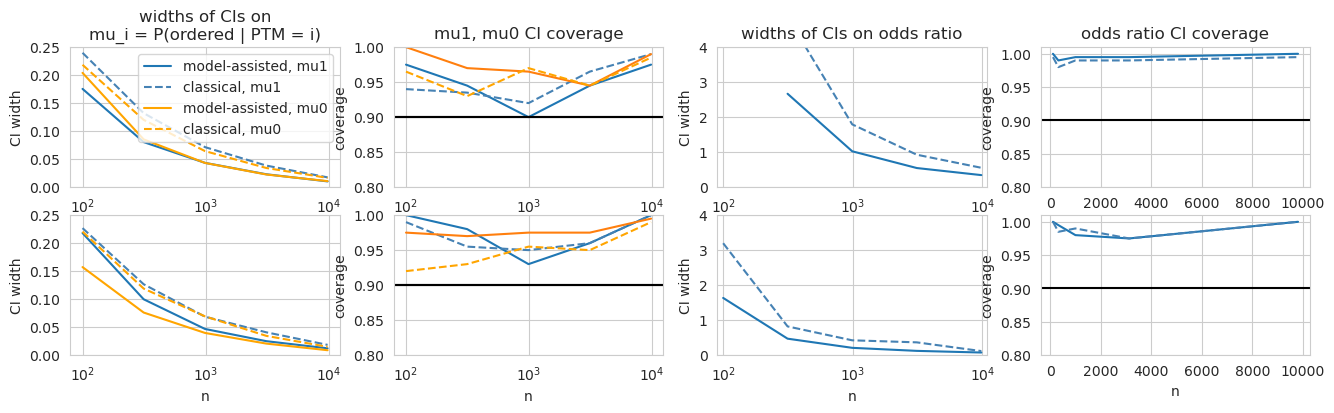

In [145]:
fig, axs = plt.subplots(len(ptm_names), 4, figsize=(16, len(ptm_names) * 2))
for p_idx, ptm_name in enumerate(ptm_names):
    
    # mu1
    mu1maicilen_n = np.mean(mu1maici_pxnxtx2[p_idx, :, :, 1] - mu1maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu1clacilen_n = np.mean(mu1claci_pxnxtx2[p_idx, :, :, 1] - mu1claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu1maicilen_n, label='model-assisted, mu1')
    axs[p_idx, 0].plot(ns, mu1clacilen_n, c='steelblue', linestyle='--', label='classical, mu1')
    
    mu1maicicov_n = np.mean(mu1cov_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu1clacicov_n = np.mean(mu1cov_pxnxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 1].plot(ns, mu1maicicov_n)
    axs[p_idx, 1].plot(ns, mu1clacicov_n, c='steelblue', linestyle='--')
    axs[p_idx, 1].set_ylim([1 - 2 * alpha, 1])
    axs[p_idx, 1].axhline(1 - alpha, c='k')
    
    # mu0
    mu0maicilen_n = np.mean(mu0maici_pxnxtx2[p_idx, :, :, 1] - mu0maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu0clacilen_n = np.mean(mu0claci_pxnxtx2[p_idx, :, :, 1] - mu0claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu0maicilen_n, c='orange', label='model-assisted, mu0')
    axs[p_idx, 0].plot(ns, mu0clacilen_n, c='orange', linestyle='--', label='classical, mu0')
    
    mu0maicicov_n = np.mean(mu0cov_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu0clacicov_n = np.mean(mu0cov_pxnxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 1].plot(ns, mu0maicicov_n)
    axs[p_idx, 1].plot(ns, mu0clacicov_n, c='orange', linestyle='--')
    axs[p_idx, 1].set_ylim([1 - 2 * alpha, 1])
    axs[p_idx, 1].axhline(1 - alpha, c='k')
    
    axs[p_idx, 0].set_xscale('log');
    axs[p_idx, 1].set_xscale('log');
    axs[p_idx, 0].set_ylabel('CI width');
    axs[p_idx, 1].set_ylabel('coverage');
    axs[p_idx, 0].set_ylim([0, 0.25]);
    
    
    # odds ratio
    omaicilen_n = np.mean(omaici_pxnxtx2[p_idx, :, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0], axis=1)
    oclacilen_n = np.mean(oclaci_pxnxtx2[p_idx, :, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0], axis=1)
    axs[p_idx, 2].plot(ns, omaicilen_n, label='model-assisted, odds ratio')
    axs[p_idx, 2].plot(ns, oclacilen_n, c='steelblue', linestyle='--', label='classical, odds ratio')
    axs[p_idx, 2].set_xscale('log');
    axs[p_idx, 2].set_xlim([90, N]);
    axs[p_idx, 2].set_ylim([0, 4]);
    axs[p_idx, 2].set_ylabel('CI width');
    
    omaicicov_n = np.mean(ocov_pxnxtx2[p_idx, :, :, 0], axis=1)
    oclacicov_n = np.mean(ocov_pxnxtx2[p_idx, :, :, 1], axis=1)
    axs[p_idx, 3].plot(ns, omaicicov_n)
    axs[p_idx, 3].plot(ns, oclacicov_n, c='steelblue', linestyle='--')
    axs[p_idx, 3].set_ylim([1 - 2 * alpha, 1.01])
    axs[p_idx, 3].axhline(1 - alpha, c='k')
    axs[p_idx, 3].set_ylabel('coverage')
    
    
for i in range(4):
    axs[-1, i].set_xlabel('n');
axs[0, 0].set_title('widths of CIs on\nmu_i = P(ordered | PTM = i)');
axs[0, 1].set_title('mu1, mu0 CI coverage');
axs[0, 2].set_title('widths of CIs on odds ratio');
axs[0, 3].set_title('odds ratio CI coverage');
axs[0, 0].legend();

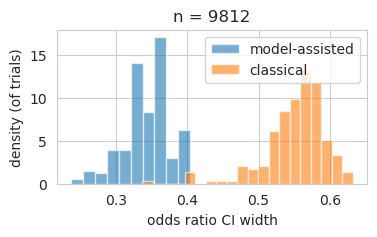

In [165]:
# for a single n 
p_idx = 0
n_idx = np.where(ns >=  5000)[0][0]

plt.figure(figsize=(4, 2))
mailen_n = omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0]
clalen_n = oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0]
plt.hist(mailen_n, alpha=0.6, density=True);
plt.hist(clalen_n, alpha=0.6, density=True, bins=20);
plt.xlabel('odds ratio CI width');
plt.ylabel('density (of trials)');
plt.legend(['model-assisted', 'classical']);
plt.title('n = {}'.format(ns[n_idx]));

In [84]:
# sanity-checking population-level variance of Y - constant (i.e. dumb predictor) vs. of Y - f
ptm_name = 'p'
z1_df = ptm_idr_df.loc[ptm_idr_df[ptm_name] == 1]
z0_df = ptm_idr_df.loc[ptm_idr_df[ptm_name] == 0]
y_z1_N = z1_df['disordered'].to_numpy()
f_z1_N = z1_df['pred_disordered'].to_numpy()
y_z0_N = z0_df['disordered'].to_numpy()
f_z0_N = z0_df['pred_disordered'].to_numpy()

In [87]:
mu_z1 = 0 # np.mean(y_z1_N)
mu_z0 = 0 # np.mean(y_z0_N)
var_dumb_z1 = np.var(y_z1_N - mu_z1)
var_dumb_z0 = np.var(y_z0_N - mu_z0)
var_yf_z1 = np.var(y_z1_N - f_z1_N)
var_yf_z0 = np.var(y_z0_N - f_z0_N)v
print(np.mean(y_z1_N), var_dumb_z1, var_yf_z1)
print(np.mean(y_z0_N), var_dumb_z0, var_yf_z0)

0.22355090516525494 0.17357589796505013 0.09166025537425192
0.1189482470784641 0.10479956159542478 0.0670063280202675


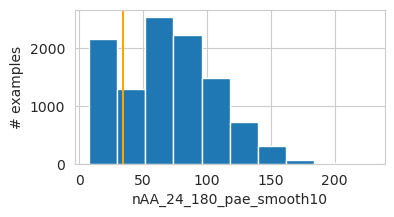

In [95]:
# scaling + logistic regression on top of pPAE!
plt.figure(figsize=(4, 2));
plt.hist(ptm_idr_df['nAA_24_180_pae_smooth10']);
thresh = 34.27 
plt.axvline(thresh, c='orange');
plt.xlabel('nAA_24_180_pae_smooth10');
plt.ylabel('# examples');